<a href="https://colab.research.google.com/github/szymonczaja/Titanic/blob/main/titanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Celem niniejszego projektu jest przeprowadzenie preedykcji przetrwania na słynnym statku titanic, sprawdzenie które cechy miały największy wpływ na przetrwanie pasażerów. Przypuszczam, że największy wþlyw na ptrzwanie miała cena biletu która jest wyznacznikiem statusu społecznego pasażera oraz to czy pasażer podróżował sam jak i płeć pasażera.

W tym notatniku przejdziemy przez następujące etapy: 1. Analiza i przygotowanie danych. 2. Budowa i porównanie modeli bazowych. 3. Dogłębne strojenie najlepszego modelu. 4. Finalna ewaluacja i interpretacja.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import shapiro
from sklearn.svm import SVC
import shap

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
passenger_id_test = test_data['PassengerId']

In [ ]:
train_data = train_data.drop(columns=['PassengerId'], axis=1)
test_data = test_data.drop(columns=['PassengerId'], axis=1)

In [ ]:
train_data.isna().mean().sort_values(ascending=False).head()

,0
Cabin,0.771044
Age,0.198653
Embarked,0.002245
Name,0.000000
Pclass,0.000000


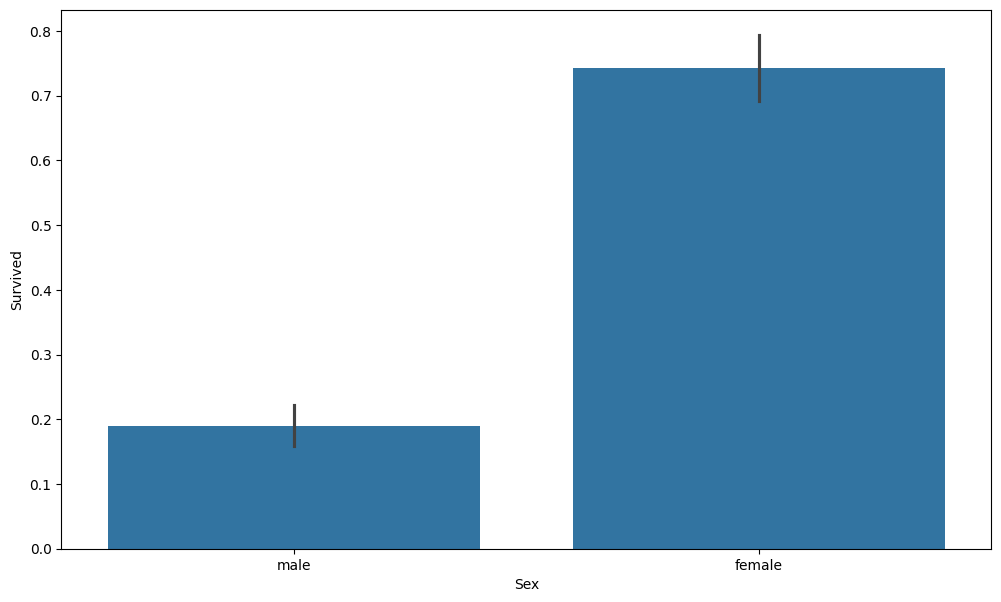

In [ ]:
plt.figure(figsize=(12,7))
sns.barplot(x=train_data['Sex'], y=train_data['Survived'])
plt.show()

Płeć jak widać ma silny związek z przeżywalnością co potwierdza ze jest to cecha o duzej mocy predykcyjnej.

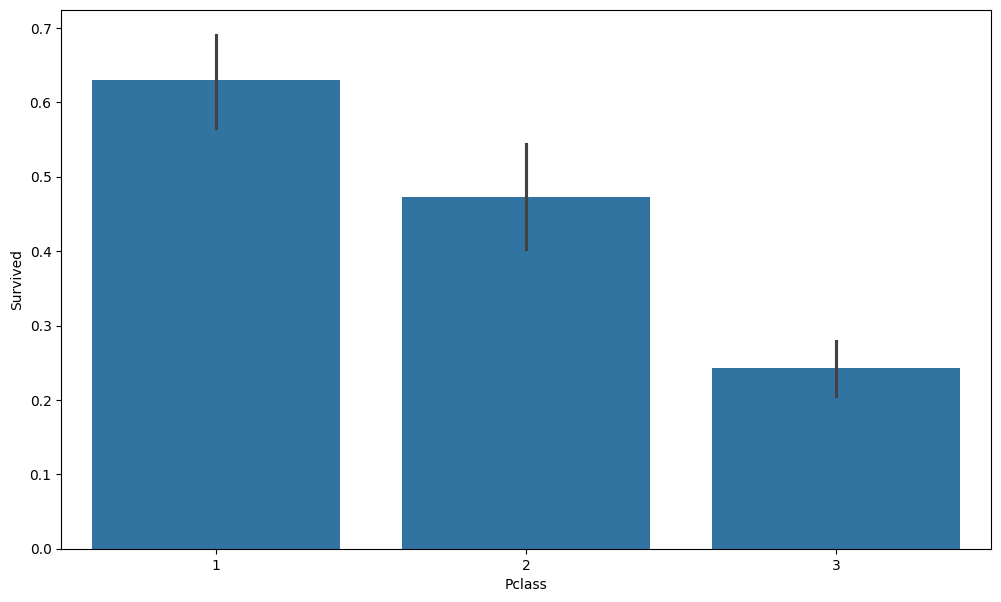

In [ ]:
plt.figure(figsize=(12,7))
sns.barplot(x=train_data['Pclass'], y=train_data['Survived'])
plt.show()

Klasa podróży silnie koreluje z przeżyciem, co potwierdza, że jest to cecha o dużej mocy predykcyjnej. Im wyższa klasa tym większe szanse na przeżcyie pasażera.

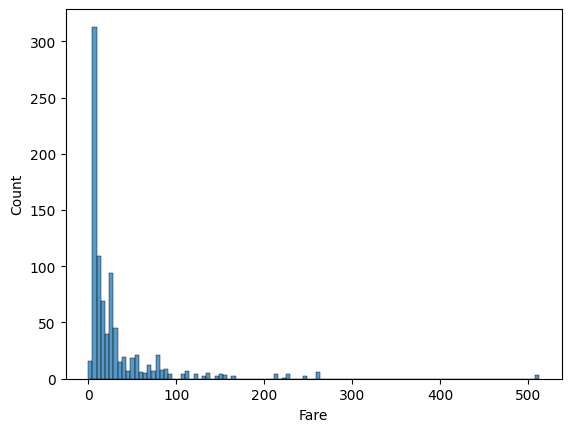

In [ ]:
sns.histplot(train_data['Fare'])
plt.show()

In [ ]:
fare_log = np.log1p(train_data['Fare'])

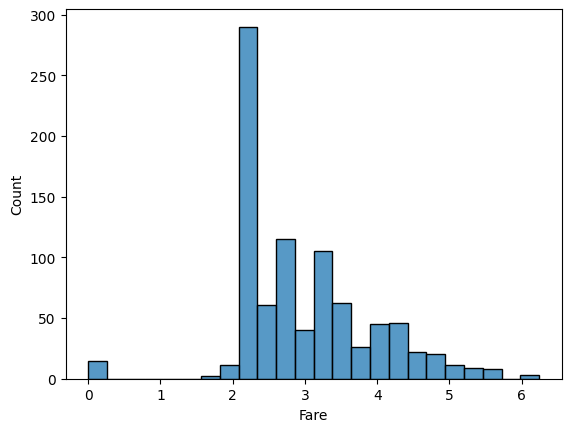

In [ ]:
sns.histplot(fare_log)
plt.show()

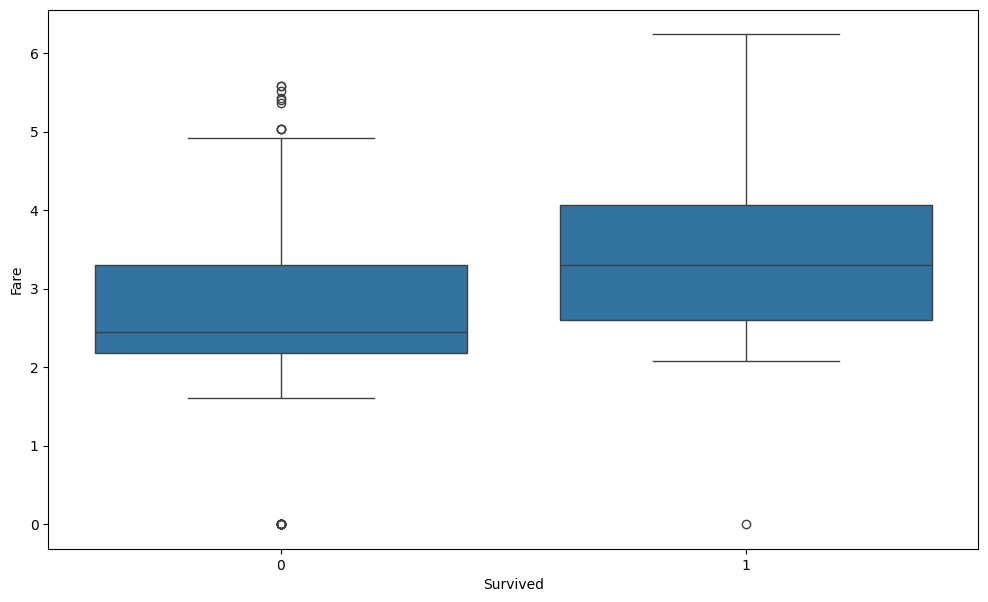

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x=train_data['Survived'], y=fare_log)
plt.show()

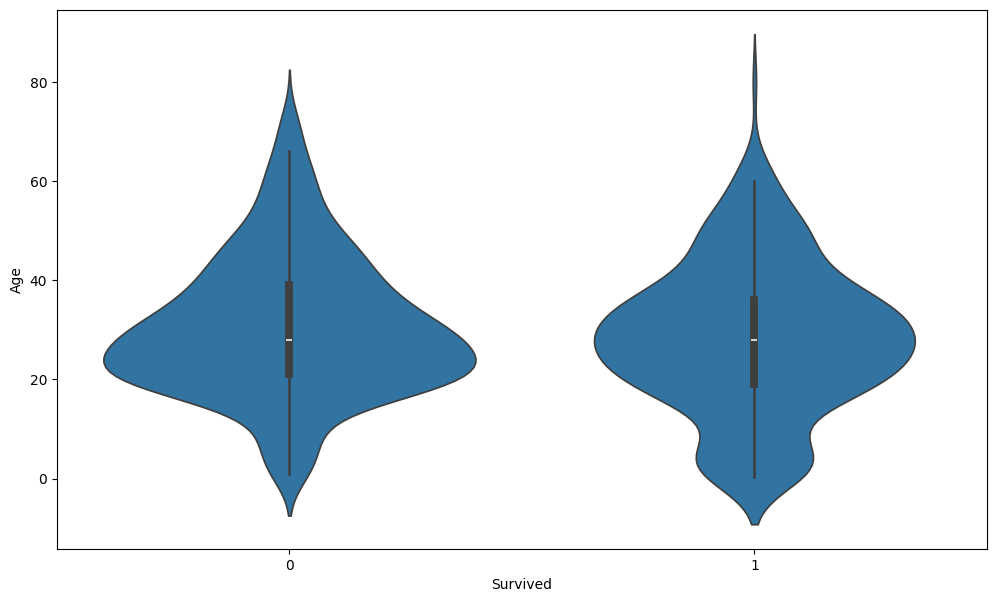

In [ ]:
plt.figure(figsize=(12, 7))
sns.violinplot(x=train_data['Survived'], y=train_data['Age'])
plt.show()

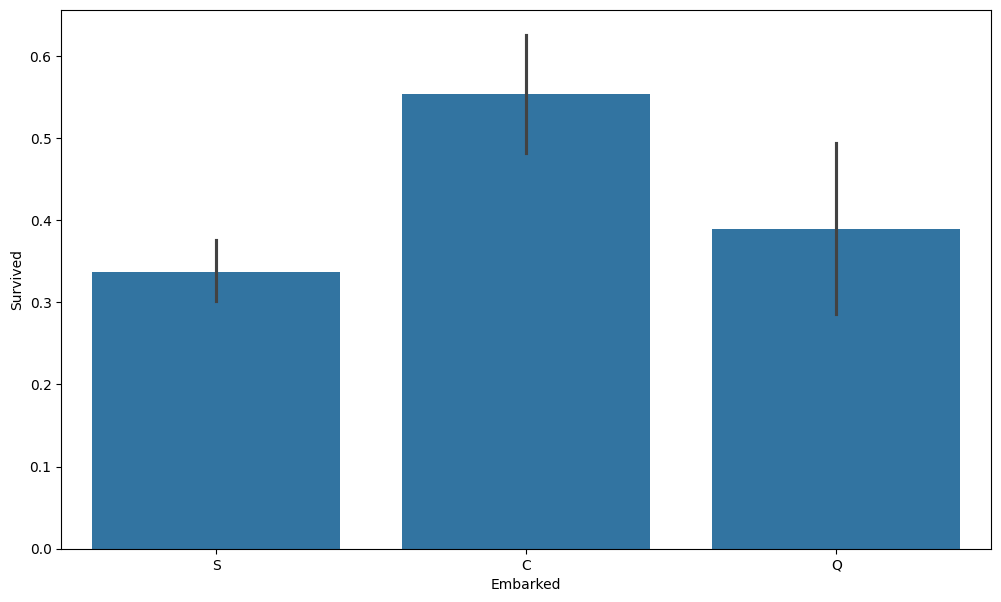

In [ ]:
plt.figure(figsize=(12,7))
sns.barplot(x=train_data['Embarked'], y=train_data['Survived'])
plt.show()

Wykres przedstawia, że pasażerowie którzy weszli na pokład w porcie C mieli większe szanse na przeżycie.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [ ]:
train_data.isna().mean().sort_values(ascending=False)

,0
Cabin,0.771044
Age,0.198653
Embarked,0.002245
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000
Fare,0.000000


In [ ]:
title_map = {
    'Mr' : 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr' : 'Rare',
    'Rev' : 'Rare',
    'Mlle': 'Miss',
    'Major': 'Rare',
    'Col' : 'Rare',
    'Countess': 'Rare',
    'Capt': 'Rare',
    'Ms' : 'Miss',
    'Sir' : 'Rare',
    'Lady': 'Rare',
    'Mme': 'Mrs',
    'Don' : 'Rare',
    'Jonkheer': 'Rare',
    'Dona' : 'Rare'
}

class FeatureEngineering(BaseEstimator, TransformerMixin):
  def __init__(self, title_map):
    self.title_map = title_map
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X_copy = X.copy()
    X_copy['Parch'] = X_copy['Parch'].fillna(0)
    X_copy['SibSp'] = X_copy['SibSp'].fillna(0)
    X_copy['FamilySize'] = (X_copy['Parch'] + X_copy['SibSp'] + 1)
    X_copy['HasCabin'] = X_copy['Cabin'].notna().astype(int)
    X_copy['IsAlone'] = (X_copy['FamilySize'] == 1).astype(int)
    X_copy['Name'] = X_copy['Name'].fillna('Unknown')
    X_copy['Title'] = X_copy['Name'].str.extract(r'([A-Za-z]+)\.')
    X_copy['Title'] = X_copy['Title'].map(self.title_map)
    X_copy['Title'] = X_copy['Title'].fillna('Rare')
    cols_for_drop = ['Parch', 'SibSp', 'Cabin', 'Name', 'Ticket']
    X_copy = X_copy.drop(columns=cols_for_drop)
    return X_copy

Na podstawie wniosków z analizy danych, tworzę nowe cechy, takie jak 'FamilySize' i 'Title', aby lepiej uchwycić relacje rodzinne i status społeczny. Cały proces czyszczenia, kodowania i skalowania zamykam w obiekcie Pipeline, aby zapewnić odtwarzalność i uniknąć wycieku danych.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [ ]:
y_train = train_data['Survived']
train_data = train_data.drop(columns=['Survived'], axis=1)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


In [ ]:
cat_nominal_cols = ['Sex', 'Embarked', 'Title']
cat_ordinal_cols = ['Pclass'] #bo klasa 1 jest lepsza niz klasa 2, 2 lepsza niz 3, jest logiczny porządek
numeric_cols = ['Age', 'Fare', 'FamilySize']
numeric_binomial_cols = ['IsAlone', 'HasCabin']

In [ ]:
nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe_encoder', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder())
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('nominal_pipeline', nominal_pipeline, cat_nominal_cols),
    ('ordinal_pipeline', ordinal_pipeline, cat_ordinal_cols),
    ('numeric_pipeline', numeric_pipeline, numeric_cols),
    ('binomial', 'passthrough', numeric_binomial_cols)
])

pre_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering(title_map=title_map)),
    ('preprocessor', preprocessor)
])


Aby znaleźć najbardziej obiecujący algorytm, przetestuję kilka różnych modeli: SVC, Regresję Logistyczną oraz XGBoost. Do ich oceny użyję walidacji krzyżowej, która da mi rzetelną ocenę ich skuteczności.

In [ ]:
models = [
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42),
    SVC(random_state=42)
]

for model in models:
  full_pipeline = Pipeline([
      ('pre_pipeline', pre_pipeline),
      ('model', model)
  ])

  scores = cross_val_score(full_pipeline, train_data, y_train, cv=5, scoring='accuracy')
  print(f'Zastosowany model: {type(model).__name__}')
  print(f'Średnia dokładność: {scores.mean():.4f}\n')


Zastosowany model: LogisticRegression
Średnia dokładność: 0.8227

Zastosowany model: RandomForestClassifier
Średnia dokładność: 0.8070

Zastosowany model: XGBClassifier
Średnia dokładność: 0.8182

Zastosowany model: SVC
Średnia dokładność: 0.8328



Z przetestowanych modeli do dalszej ewaulacji wybieram model maszyn wektorów nośnych ponieważ wykazał on się największą dokładnością w klasyfikacji pasażerów w kontekście przetrwania.

In [ ]:
'''svc_pipeline = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('svc', SVC(random_state=42))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
      }
grid_search_svc = GridSearchCV(estimator=svc_pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1,
                               verbose=2)
grid_search_svc.fit(train_data, y_train)
print(f'Najlepsze parametry: {grid_search_svc.best_params_}')
print(f'Najlepszy wynik: {grid_search_svc.best_score_:.4f}')'''

"svc_pipeline = Pipeline([\n    ('pre_pipeline', pre_pipeline),\n    ('svc', SVC(random_state=42))\n])\n\nparam_grid = {\n    'svc__C': [0.1, 1, 10, 100],\n    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],\n    'svc__gamma': ['scale', 'auto', 0.1, 0.01, 0.001]\n      }\ngrid_search_svc = GridSearchCV(estimator=svc_pipeline,\n                               param_grid=param_grid,\n                               scoring='accuracy',\n                               cv=5,\n                               n_jobs=-1,\n                               verbose=2)\ngrid_search_svc.fit(train_data, y_train)\nprint(f'Najlepsze parametry: {grid_search_svc.best_params_}')\nprint(f'Najlepszy wynik: {grid_search_svc.best_score_:.4f}')"

W wyniku bardz długiego działania rezygnuje z GridSearchCV na rzecz kompromisu pomiędzy czasem obliczeń a uzyskanym wynikiem, następnie przeprowadzam lżejsze przeszukiwanie najlepszych hiperaparametrow modelu SVC() poprzez RandomizedSearchCV() które w sposób losowy przeszukuje dane.

In [ ]:
X_train = train_data.copy()

In [ ]:
lr_pipeline = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])



param_grid_lr = [{
     'model__penalty': ['l1'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga']
},
{
    'model__penalty': ['l2'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs'],
}]

grid_search_lr = GridSearchCV(estimator=lr_pipeline,
                              param_grid=param_grid_lr,
                              scoring='accuracy',
                              cv=5,
                              verbose=2,
                              n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
print(f'Najlepszy wynik: {grid_search_lr.best_score_:.4f}')
print(f'Najlepsze parametry: {grid_search_lr.best_params_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Najlepszy wynik: 0.8283
Najlepsze parametry: {'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


Przestrzeń parametrów jest zbyt duża na pełne przeszukanie XGB. Używam RandomizedSearchCV do szybkiego znalezienia obiecujących regionów w tej przestrzeni

In [ ]:
xgb_pipeline = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('model', XGBClassifier(random_state=42))
])

param_dist_xgb = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__gamma': [0.0, 0.1, 0.5],
    'model__reg_lambda': [0.5, 1, 2],
    'model__reg_alpha': [0, 0.005, 0.05],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

rnd_search_xgb = RandomizedSearchCV(estimator=xgb_pipeline,
                               param_distributions=param_dist_xgb,
                               n_iter=100,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1,
                               verbose=2,
                                random_state=42)
rnd_search_xgb.fit(X_train, y_train)
print(f'Najlepszy wynik dla xgb: {rnd_search_xgb.best_score_:.4f}')
print(f'Najlepsze parametry dla xgb: {rnd_search_xgb.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Najlepszy wynik dla xgb: 0.8451
Najlepsze parametry dla xgb: {'model__subsample': 0.8, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0.005, 'model__n_estimators': 500, 'model__max_depth': 9, 'model__learning_rate': 0.01, 'model__gamma': 0.5, 'model__colsample_bytree': 0.8}


Najlepsza dokładność jaką uzyskalismy dla Klasyfikatora XGBoost wynosi 0.8451 oznacza to że model klasyfikuje ok. 84% przypadków prawidłowo.
Najlepszy parametry learning_rate 0.01 i n_estimators=500 oznacza że model osiąga najlepsze wyniki ucząc się bardzo powoli przez długi czas przez co jest dokładniejszy. Model wybrał najgłębszą możliwą głębokość (max_depth=9) co oznacza że w danych istnieją złożone interakcje, a model potrzebuje przestrzeni do ich wychwycenia.
Wartości subsample, colsample_bytree, reg_lambda i gamma są różne od domyślnych. To pokazuje, że wprowadzenie losowości i regularyzacji pomaga modelowi w generalizacji i unikaniu przeuczenia.

Wyniki z RandomizedSearchCV pozwoliły mi zawęzić poszukiwania. Teraz używam GridSearchCV do precyzyjnego dostrojenia parametrów w tym obiecującym zakresie.

In [ ]:
xgb_pipeline_final = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('model', XGBClassifier(random_state=42))
])

param_grid_xgb = {
    'model__n_estimators': [450, 500, 550],
    'model__max_depth': [8, 9, 10],
    'model__learning_rate': [0.005, 0.01, 0.02],
    'model__gamma': [0.5],
    'model__reg_lambda': [0.5],
    'model__reg_alpha': [0.005],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}
grid_search_xgb = GridSearchCV(estimator=xgb_pipeline_final,
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2
                               )
grid_search_xgb.fit(X_train, y_train)
print(f'Najlepszy wynik: {grid_search_xgb.best_score_:.4f}')
print(f'Najlepsze parametry: {grid_search_xgb.best_params_}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Najlepszy wynik: 0.8474
Najlepsze parametry: {'model__colsample_bytree': 0.8, 'model__gamma': 0.5, 'model__learning_rate': 0.005, 'model__max_depth': 10, 'model__n_estimators': 550, 'model__reg_alpha': 0.005, 'model__reg_lambda': 0.5, 'model__subsample': 0.8}


In [ ]:
xgb_pipeline_final = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('model', XGBClassifier(random_state=42))
])

param_grid_xgb = {
    'model__n_estimators': [550],
    'model__max_depth': [10],
    'model__learning_rate': [0.005],
    'model__gamma': [0.4, 0.5, 0.6],
    'model__reg_lambda': [0.4, 0.5, 0.6],
    'model__reg_alpha': [0.004, 0.005, 0.006],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search_xgb2 = GridSearchCV(estimator=xgb_pipeline_final,
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2
                               )
grid_search_xgb2.fit(X_train, y_train)
print(f'Najlepszy wynik: {grid_search_xgb2.best_score_:.4f}')
print(f'Najlepsze parametry: {grid_search_xgb2.best_params_}')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Najlepszy wynik: 0.8474
Najlepsze parametry: {'model__colsample_bytree': 0.8, 'model__gamma': 0.5, 'model__learning_rate': 0.005, 'model__max_depth': 10, 'model__n_estimators': 550, 'model__reg_alpha': 0.005, 'model__reg_lambda': 0.5, 'model__subsample': 0.8}


Po znalezieniu optymalnych hiperparametrów, przeprowadzam finalną ewaluację modelu. Używam macierzy pomyłek i krzywej ROC, aby zrozumieć jego mocne i słabe strony, a następnie biblioteki SHAP, aby wyjaśnić, na podstawie jakich cech podejmuje decyzje.

In [ ]:
best_xgb_pipeline = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('model', XGBClassifier(random_state=42))
])

best_params = grid_search_xgb2.best_params_
best_xgb_pipeline.set_params(**best_params)

Pipeline(steps=[('pre_pipeline',
                 Pipeline(steps=[('feature_engineering',
                                  FeatureEngineering(title_map={'Capt': 'Rare',
                                                                'Col': 'Rare',
                                                                'Countess': 'Rare',
                                                                'Don': 'Rare',
                                                                'Dona': 'Rare',
                                                                'Dr': 'Rare',
                                                                'Jonkheer': 'Rare',
                                                                'Lady': 'Rare',
                                                                'Major': 'Rare',
                                                                'Master': 'Master',
                                                                'Miss': 'Miss',
                                                                'Mlle': 'Miss',
                                                                'Mme': 'Mrs',
                                                                'Mr': 'Mr',
                                                                'Mrs': 'Mrs',
                                                                'Ms': 'Miss',
                                                                'Rev': 'Rare',
                                                                'Sir': 'Rare'}...
                               feature_types=None, feature_weights=None,
                               gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=550,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
svc_pipeline = Pipeline([
    ('pre_pipeline', pre_pipeline),
    ('svc', SVC(random_state=42, probability=True))
])

In [ ]:
y_proba_lr = cross_val_predict(lr_pipeline, X_train, y_train, cv=5, method='predict_proba')
y_proba_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=5, method='predict_proba')
y_proba_svc = cross_val_predict(svc_pipeline, X_train, y_train, cv=5, method='predict_proba')

In [ ]:
y_proba_ensemble = (y_proba_lr + y_proba_xgb + y_proba_svc) /3

In [ ]:
survived_probabilities_ensemble = y_proba_ensemble[:, 1]

y_pred_ensemble = (survived_probabilities_ensemble > 0.5).astype(int)

ensemble_accuracy = accuracy_score(y_train, y_pred_ensemble)

print(f"Wynik samego XGBoost (z CV): {grid_search_xgb2.best_score_:.4f}")
print(f"Wynik ensemblingu (z CV): {ensemble_accuracy:.4f}")

Wynik samego XGBoost (z CV): 0.8474
Wynik ensemblingu (z CV): 0.8429


In [ ]:
y_train_pred = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=5, method='predict')
y_train_pred_proba = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=5, method='predict_proba')

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.84      0.74      0.79       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.83       891
weighted avg       0.85      0.85      0.85       891



Recall- 0.74 dla klasy 1 oznacza, że model prawidłowo sklasyfikował 74% osób które faktycznie przeżyły, pozostałe 26% to 88 osób które widzimy na macierzy pomyłek które model przegapił.

Precision-0.84 oznacza, że gdy model 'twierdzi' że ktoś przeżył ma racje w 84% przypadków, pozostałe 16% to osoby które dostały fałszywą nadzieję na przeżycie.

Accuracy-0.85 oznacza że model prawidłowo przewidział 85% przypadków

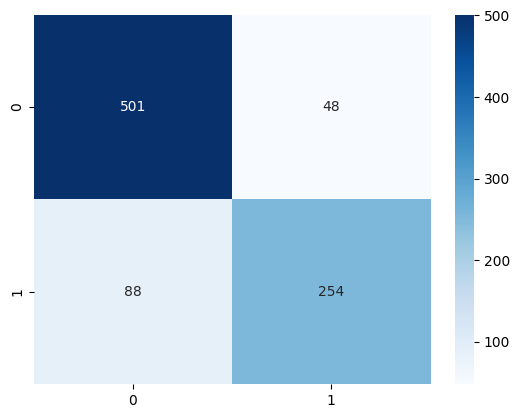

In [ ]:
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

501 przypadków prawdziwie negatywnych czyli tych które nie przeżyły

48 przypadków fałszywie negatywnych czyli tych ktore prezyly a zostaly sklasyfikowane jako te ktore nie przezyly

88 przypadków fałszywie pozytywnych czyli przypadkow ktore zostaly sklasyfikowane fałszywie jako te ktore przezyly

254 przypadki prawdziwie pozytywne prawidlowo sklasyfikowane przypadki ktore przezyly


ROC AUC Score: 0.8721


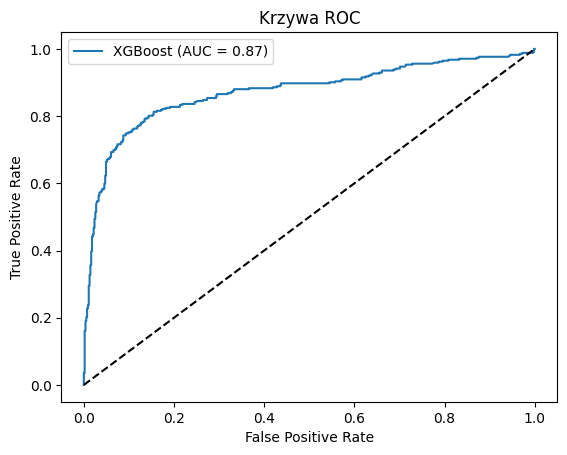

In [ ]:
auc_score = roc_auc_score(y_train, y_train_pred_proba[:, 1])
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba[:, 1])
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend()
plt.show()

Wynik ROC AUC Score 0.8721 mówi nam o tym, że gdybyśmy wzieli losową osobę która przeżyła i losową osobę która nie przeżyła to istnieje 87% szans ze model przypiszę wyższe prawdopodobieństwo przeżycia osobie pierwszej.

Krzywa co widzimy na wykresie mocno wygięta w strone lewege górnego rogu pokazuje że model jest znacznie lepszy w swoich przewidywaniach niż losowe zgadywanie które na wykresie oznaczone jest linią przerywaną.

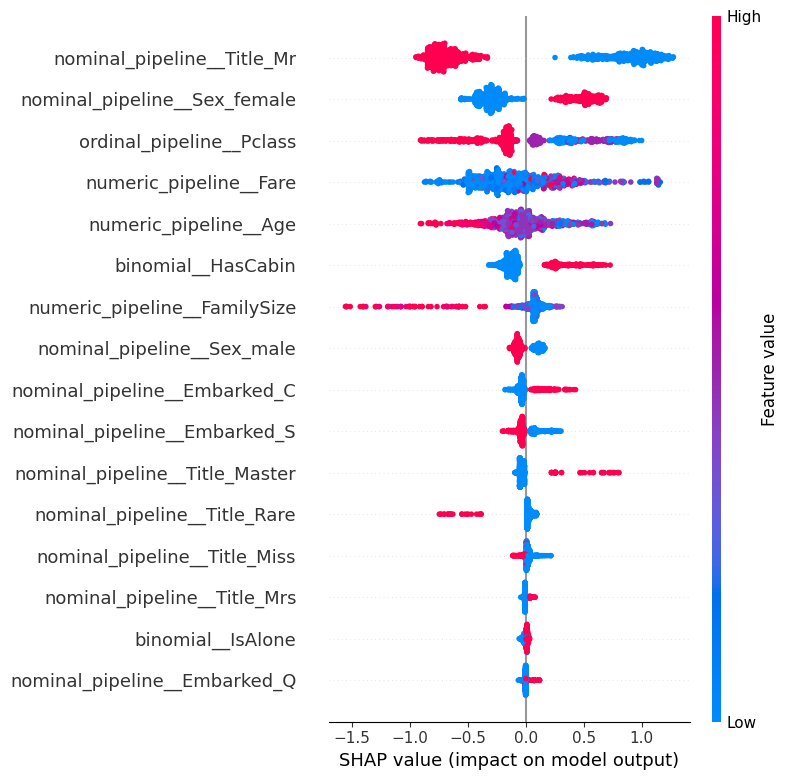

In [ ]:
final_model = grid_search_xgb2.best_estimator_
pre_pipeline = final_model.named_steps['pre_pipeline']

column_transformer_step = pre_pipeline.named_steps['preprocessor']
feature_names = column_transformer_step.get_feature_names_out()
X_train_processed = pre_pipeline.transform(X_train)
model_xgb = final_model.named_steps['model']
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train_processed)

shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names)

Title_Mr (Tytuł "Pan"):

Wniosek: Posiadanie tytułu "Mr" było najsilniejszym czynnikiem wskazującym na brak szans na przeżycie. Model doskonale nauczył się, że dorośli mężczyźni mieli najniższy priorytet przy ewakuacji.

Sex_female (Płeć żeńska):

Wniosek: Bycie kobietą drastycznie zwiększało szanse na przeżycie. To odzwierciedlenie zasady "kobiety i dzieci w pierwszej kolejności".

Pclass (Klasa biletu):

Wniosek: Podróż w 3. klasie mocno zmniejszała szanse na przeżycie, podczas gdy podróż w 1. klasie je zwiększała.

Fare (Cena biletu): Działa bardzo podobnie do Pclass. Wysoka opłata (czerwone punkty) zwiększa szanse na przeżycie, niska (niebieskie punkty) je zmniejsza.

Age (Wiek):

Wniosek: Bycie dzieckiem znacząco zwiększało szanse na przeżycie. Model poprawnie wychwycił drugą część zasady "kobiety i dzieci w pierwszej kolejności".

HasCabin (Posiadanie kabiny): Posiadanie kabiny (czerwone punkty) pcha predykcję w prawo (przeżycie).

Wniosek: Posiadanie zarejestrowanej kabiny (co było typowe dla wyższych klas) było pozytywnym sygnałem.

FamilySize (Rozmiar rodziny): Czerwone punkty (duża rodzina) mają silnie ujemny wpływ.

Wniosek: Podróżowanie w dużej rodzinie zmniejszało szanse na przeżycie. Jest to klasyczna obserwacja z Titanica – zebranie i ewakuacja dużej grupy była logistycznie bardzo trudna.

In [ ]:
y_test_pred = final_model.predict(test_data)

In [ ]:
submission = pd.DataFrame({
    'PassengerId': passenger_id_test,
    'Survived' : y_test_pred
})

In [ ]:
submission.to_csv('titanic_colab_submission.csv', index=False)

W ramach projektu zbudowałem i zoptymalizowałem model XGBoost, który osiągnął dokładność 84,74% na walidacji krzyżowej. Analiza interpretacyjna SHAP potwierdziła historyczne realia, wskazując, że tytuł 'Mr', klasa podróży oraz płeć były kluczowymi czynnikami decydującymi o przeżyciu. Cały proces został zautomatyzowany przy użyciu scikit-learn Pipeline, co zapewnia pełną odtwarzalność wyników.